In [38]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.stats import poisson

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.ticker import MultipleLocator, MaxNLocator
import matplotlib.gridspec as gridspec
import seaborn as sns

from pyabc import ABCSMC, Distribution, RV, MedianEpsilon, QuantileEpsilon
from pyabc.visualization import plot_kde_matrix
import tempfile
import pymc as pm
import arviz as az
import pytensor.tensor as pt
from pytensor.tensor.special import gammaln
from numpy.polynomial.laguerre import laggauss


from tqdm.autonotebook import tqdm

plt.rcParams.update({
    "mathtext.fontset": "stix",
    "font.family": "STIXGeneral",
    "legend.fontsize": 12,
    "legend.title_fontsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 18,
})
mpl.rcParams['animation.embed_limit'] = 2000


## Generate the synthetic data

In [30]:
class insilico_experiment:
    def __init__(
        self,
        kill_lambda_avg: float = 3.0,
        kill_lambda_sd: float = 1.0,
        Num_killers_obs: int = 300,
        random_seed: int = 66
    ):
        self.kill_lambda_avg = kill_lambda_avg
        self.kill_lambda_sd = kill_lambda_sd
        self.Num_killers_obs = Num_killers_obs
        self.random_seed = random_seed
        
        self.lambdas, self.kills = self._generate_data()
    
    def _generate_data(self):
        rng = np.random.default_rng(self.random_seed)
        shape = self.kill_lambda_avg**2 / self.kill_lambda_sd**2
        scale = self.kill_lambda_sd**2 / self.kill_lambda_avg
        lambdas = rng.gamma(shape, scale, self.Num_killers_obs)
        kills = rng.poisson(lambdas)
        return lambdas, kills
    
    def regenerate(self, new_seed: int = None):
        if new_seed is not None:
            self.random_seed = new_seed
        self.lambdas, self.kills = self._generate_data()
        
    def get_summary(self):
        return {
            "kill_lambda_avg": self.kill_lambda_avg,
            "kill_lambda_sd": self.kill_lambda_sd,
            "lambdas": self.lambdas,
            "kills": self.kills,
            "killer_number": self.Num_killers_obs
        }


In [31]:
NO_CELL = 5000


lambda_avg_list = [0.5, 1.2, 2]
lambda_sd_list = [0.05, 0.2, 0.4]
cell_num_list = [NO_CELL, NO_CELL, NO_CELL]


experiment = {}
for i, lambda_avg in enumerate(lambda_avg_list):
    lambda_sd = lambda_sd_list[i]

    experiment[i] = insilico_experiment(
        kill_lambda_avg=lambda_avg,
        kill_lambda_sd=lambda_sd,
        Num_killers_obs=cell_num_list[i],
        random_seed=i
    )

/var/folders/rr/16wv6ts1785fz6_2qhr5bc2m0000gn/T/ipykernel_23886/2983531003.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('YlGnBu')


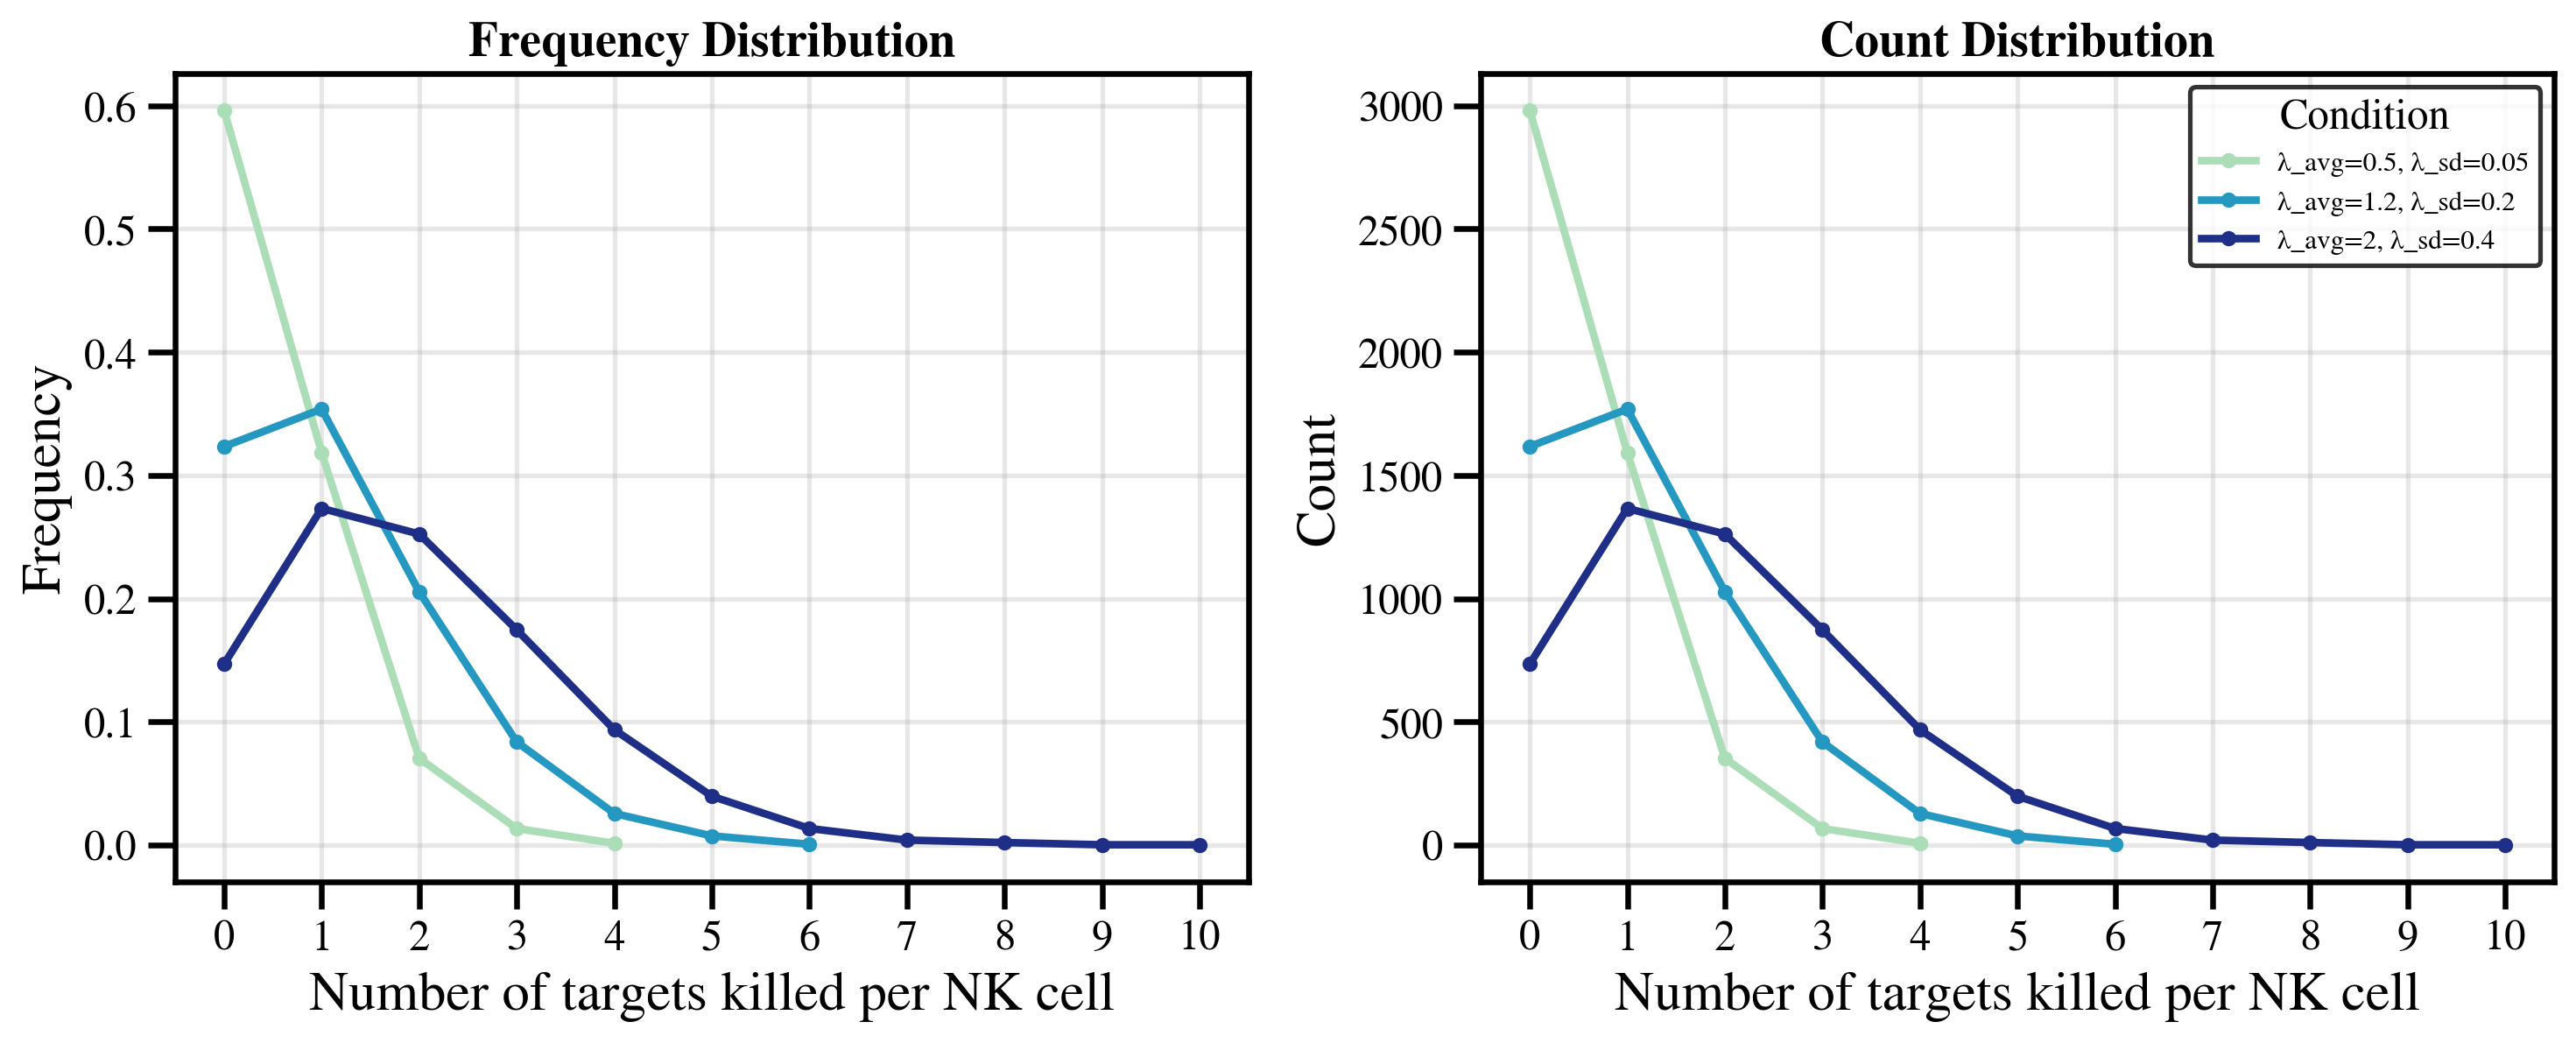

In [32]:
conditions = [
    f"λ_avg={lambda_avg_list[i]}, λ_sd={lambda_sd_list[i]}" 
    for i in range(len(lambda_avg_list))
]

cmap = get_cmap('YlGnBu')
colors = cmap(np.linspace(0.3, 0.9, len(conditions)))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=250, sharex=True)
ax_freq, ax_count = axes

for i, cond_name in enumerate(conditions):
    colour = colors[i]
    
    kills = experiment[i].get_summary()['kills']
    n_cells = len(kills)
    max_kills = int(kills.max())
    counts = np.bincount(kills, minlength=max_kills + 1)
    freq = counts / n_cells if n_cells > 0 else np.zeros_like(counts)
    x = np.arange(len(counts))
    
    ax_freq.plot(x, freq, color=colour, linewidth=2.5, label=cond_name, marker='o', markersize=4)
    ax_count.plot(x, counts, color=colour, linewidth=2.5, label=cond_name, marker='o', markersize=4)

ax_freq.set_title("Frequency Distribution", fontweight='bold')
ax_count.set_title("Count Distribution", fontweight='bold')
ax_freq.set_ylabel("Frequency")
ax_count.set_ylabel("Count")

for ax in (ax_freq, ax_count):
    ax.set_xlabel("Number of targets killed per NK cell")
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.grid(True, alpha=0.3)

ax_count.legend(title="Condition", frameon=True, edgecolor='black', loc='upper right', fontsize=9)
plt.tight_layout()
# plt.savefig("./synthetic_data_plots.pdf", dpi=500, bbox_inches="tight")
plt.show()


In [33]:
summary_data = []

for i in range(len(experiment)):
    exp = experiment[i]
    kills = exp.kills
    lambdas = exp.lambdas
    
    summary_data.append({
        'Experiment': i,
        'λ_avg (input)': exp.kill_lambda_avg,
        'λ_sd (input)': exp.kill_lambda_sd,
        'λ_mean (actual)': np.mean(lambdas),
        'λ_std (actual)': np.std(lambdas),
        'Kills_mean': np.mean(kills),
        'Kills_std': np.std(kills),
        'Kills_min': np.min(kills),
        'Kills_max': np.max(kills),
        'Zero_kills (%)': 100 * np.sum(kills == 0) / len(kills),
    })

df_summary = pd.DataFrame(summary_data)
print("Summary Statistics for Synthetic Experiments:")
print("=" * 120)
print(df_summary.to_string(index=False))
print("=" * 120)


Summary Statistics for Synthetic Experiments:
 Experiment  λ_avg (input)  λ_sd (input)  λ_mean (actual)  λ_std (actual)  Kills_mean  Kills_std  Kills_min  Kills_max  Zero_kills (%)
          0            0.5          0.05         0.500932        0.050243      0.5050   0.698552          0          4           59.64
          1            1.2          0.20         1.195790        0.199506      1.1588   1.096350          0          6           32.34
          2            2.0          0.40         2.004166        0.403453      2.0024   1.474718          0         10           14.68


## Bayesian Inference

In [64]:
def inference_one_ABC(
    kills_per_cell,
    draws=5000,
    pop_size=500,
    max_populations=20,
    seed=66,
    distance_type="L1"
):
    y_obs = np.asarray(kills_per_cell, dtype=int)
    hist_bins = np.arange(0, max(y_obs) + 2)
    hist_obs, _ = np.histogram(y_obs, bins=hist_bins, density=True)
    obs_data = {"hist": hist_obs}

    def simulator(params):
        mu = params["mu_lambda"]
        sigma = params["sigma_lambda"]
        exp = insilico_experiment(
            kill_lambda_avg=mu, kill_lambda_sd=sigma,
            Num_killers_obs=len(y_obs),
            random_seed=np.random.randint(1e9))
        hist, _ = np.histogram(exp.kills, bins=hist_bins, density=True)
        return {"hist": hist}

    def distance(sim, obs):
        p_sim, p_obs = sim["hist"], obs["hist"]
        n = max(len(p_sim), len(p_obs))
        p_sim = np.pad(p_sim, (0, n - len(p_sim)))
        p_obs = np.pad(p_obs, (0, n - len(p_obs)))
        if distance_type == "L1":
            return np.sum(np.abs(p_sim - p_obs))
        elif distance_type == "L2":
            return np.sqrt(np.sum((p_sim - p_obs) ** 2))
        elif distance_type == "L3":
            return np.cbrt(np.sum(np.abs(p_sim - p_obs) ** 3))
        else:
            raise ValueError("distance_type must be 'L1', 'L2', or 'L3'")

    prior = Distribution(
        mu_lambda=RV("uniform", 0.1, 5.0),
        sigma_lambda=RV("uniform", 0.01, 2.0),
    )

    abc = ABCSMC(
        simulator,
        prior,
        distance,
        population_size=pop_size,
        # eps=MedianEpsilon(0.5),
        eps=QuantileEpsilon(alpha=0.7)
    )

    db_path = "sqlite:///" + tempfile.mkstemp(prefix="abc_", suffix=".db")[1]
    history = abc.new(db_path, obs_data)
    history = abc.run(max_nr_populations=max_populations)

    df, weights = history.get_distribution()
    samples = df.sample(n=min(draws, len(df)), replace=True, weights=weights, random_state=seed)
    posterior = {
        "mu_lambda": samples["mu_lambda"].values,
        "sigma_lambda": samples["sigma_lambda"].values,
    }
    posterior_df = pd.DataFrame(posterior)
    idata = az.from_dict(posterior=posterior_df.to_dict(orient="list"))
    return idata

def inference_one_ABC_v2(
    kills_per_cell,
    draws=3000,
    pop_size=800,
    max_populations=20,
    seed=66,
    distance_type="L2"
):
    y_obs = np.asarray(kills_per_cell, dtype=int)
    hist_bins = np.arange(0, max(y_obs) + 2)
    hist_obs, _ = np.histogram(y_obs, bins=hist_bins, density=True)
    obs_data = {"hist": hist_obs, "mean": np.mean(y_obs), "var": np.var(y_obs)}

    def simulator(params):
        mu = params["mu_lambda"]
        sigma = params["sigma_lambda"]
        exp = insilico_experiment(kill_lambda_avg=mu, kill_lambda_sd=sigma,
                                  Num_killers_obs=len(y_obs),
                                  random_seed=np.random.randint(1e9))
        hist, _ = np.histogram(exp.kills, bins=hist_bins, density=True)
        return {"hist": hist, "mean": np.mean(exp.kills), "var": np.var(exp.kills)}

    def distance(sim, obs):
        p_sim, p_obs = sim["hist"], obs["hist"]
        n = max(len(p_sim), len(p_obs))
        p_sim = np.pad(p_sim, (0, n - len(p_sim)))
        p_obs = np.pad(p_obs, (0, n - len(p_obs)))
        if distance_type == "L1":
            d_hist = np.sum(np.abs(p_sim - p_obs))
        elif distance_type == "L2":
            d_hist = np.sqrt(np.sum((p_sim - p_obs) ** 2))
        elif distance_type == "L3":
            d_hist = np.cbrt(np.sum(np.abs(p_sim - p_obs) ** 3))
        else:
            raise ValueError("distance_type must be 'L1', 'L2', or 'L3'")
        d_mean = abs(sim["mean"] - obs["mean"])
        d_var = abs(sim["var"] - obs["var"])
        return d_hist + 0.5 * d_mean + 0.2 * d_var

    prior = Distribution(
        mu_lambda=RV("loguniform", 10**-1, 10**1),
        sigma_lambda=RV("halfnorm", 0.0, 1.0),
        # mu_lambda=RV("uniform", 0.1, 3.0),
        # sigma_lambda=RV("uniform", 0.01, 1.0),
    )

    abc = ABCSMC(
        simulator,
        prior,
        distance,
        population_size=pop_size,
        eps=QuantileEpsilon(alpha=0.7),
    )

    db_path = "sqlite:///" + tempfile.mkstemp(prefix="abc_", suffix=".db")[1]
    history = abc.new(db_path, obs_data)
    history = abc.run(max_nr_populations=max_populations)

    df, weights = history.get_distribution()
    samples = df.sample(n=min(draws, len(df)), replace=True, weights=weights, random_state=seed)
    posterior = {
        "mu_lambda": samples["mu_lambda"].values,
        "sigma_lambda": samples["sigma_lambda"].values,
    }
    posterior_df = pd.DataFrame(posterior)
    idata = az.from_dict(posterior=posterior_df.to_dict(orient="list"))
    return idata

def inference_one_ABC_v3(kills_per_cell, draws=3000, pop_size=1000, max_populations=25, seed=66):
    from scipy.stats import gaussian_kde, skew
    y_obs = np.asarray(kills_per_cell, dtype=int)
    obs_data = {"y": y_obs, "mean": np.mean(y_obs), "var": np.var(y_obs), "skew": skew(y_obs)}

    def simulator(params):
        mu, sigma = params["mu_lambda"], params["sigma_lambda"]
        exp = insilico_experiment(mu, sigma, Num_killers_obs=len(y_obs),
                                  random_seed=np.random.randint(1e9))
        y = exp.kills
        return {"y": y, "mean": np.mean(y), "var": np.var(y), "skew": skew(y)}

    def distance(sim, obs):
        grid = np.linspace(0, max(max(sim["y"]), max(obs["y"])) + 1, 200)
        kde_sim, kde_obs = gaussian_kde(sim["y"]), gaussian_kde(obs["y"])
        f_sim, f_obs = kde_sim(grid), kde_obs(grid)
        d_kde = np.trapz(np.abs(f_sim - f_obs), grid)
        d_mean = abs(sim["mean"] - obs["mean"])
        d_var = abs(sim["var"] - obs["var"])
        d_skew = abs(sim["skew"] - obs["skew"])
        return d_kde + 0.2*d_mean + 0.1*d_var + 0.05*d_skew

    from pyabc import ABCSMC, Distribution, RV, QuantileEpsilon
    import tempfile, pandas as pd, arviz as az

    prior = Distribution(
        mu_lambda=RV("loguniform", 10**-1, 10**1),
        sigma_lambda=RV("halfnorm", 0.0, 1.0),
    )

    abc = ABCSMC(simulator, prior, distance, population_size=pop_size, eps=QuantileEpsilon(alpha=0.4))
    db_path = "sqlite:///" + tempfile.mkstemp(prefix="abc_", suffix=".db")[1]
    abc.new(db_path, obs_data)
    hist = abc.run(max_nr_populations=max_populations)
    df, w = hist.get_distribution()
    s = df.sample(n=min(draws, len(df)), replace=True, weights=w, random_state=seed)
    return az.from_dict(posterior=s.to_dict(orient="list"))

def inference_all(
    experiment, labels=None,
    draws=5000, pop_size=500, max_populations=10, seed=66, distance_type="L1"
    ):
    if labels is None:
        labels = [f"cond_{i}" for i in range(len(experiment))]

    out = []
    for i in range(len(experiment)):
        current_seed = seed + i if seed is not None else None
        idata = inference_one_ABC_v3(
            kills_per_cell=experiment[i].get_summary()["kills"],
            draws=draws, pop_size=pop_size,
            max_populations=max_populations, 
            # distance_type=distance_type,
            seed=current_seed
        )
        out.append((labels[i], idata))
    return out

In [65]:
conditions = [
    f"λ_avg={lambda_avg_list[i]}, λ_sd={lambda_sd_list[i]}" 
    for i in range(len(lambda_avg_list))
]
ground_truth_values = {}
for i, cond_label in enumerate(conditions):
    ground_truth_values[cond_label] = {
        "mu_lambda": experiment[i].kill_lambda_avg,
        "sigma_lambda": experiment[i].kill_lambda_sd
    }   


idatas = inference_all(
    experiment=list(experiment.values()),
    labels=conditions, 
    draws=5000,
    pop_size=1000,
    max_populations=15,
    seed=None,
    # distance_type="L3"
)

ABC.Sampler INFO: Parallelize sampling on 12 processes.
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-11-06 13:54:51>
ABC INFO: Calibration sample t = -1.
/var/folders/rr/16wv6ts1785fz6_2qhr5bc2m0000gn/T/ipykernel_23886/2135058180.py:150: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  d_kde = np.trapz(np.abs(f_sim - f_obs), grid)
ABC INFO: t: 0, eps: 9.26776808e-01.
/var/folders/rr/16wv6ts1785fz6_2qhr5bc2m0000gn/T/ipykernel_23886/2135058180.py:150: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
/var/folders/rr/16wv6ts1785fz6_2qhr5bc2m0000gn/T/ipykernel_23886/2135058180.py:150: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
/var/folders/rr/16wv6ts1785fz6_2qhr5bc2m0000gn/T/ipykernel_23886/2135058180.py:150: Deprecat

KeyboardInterrupt: 

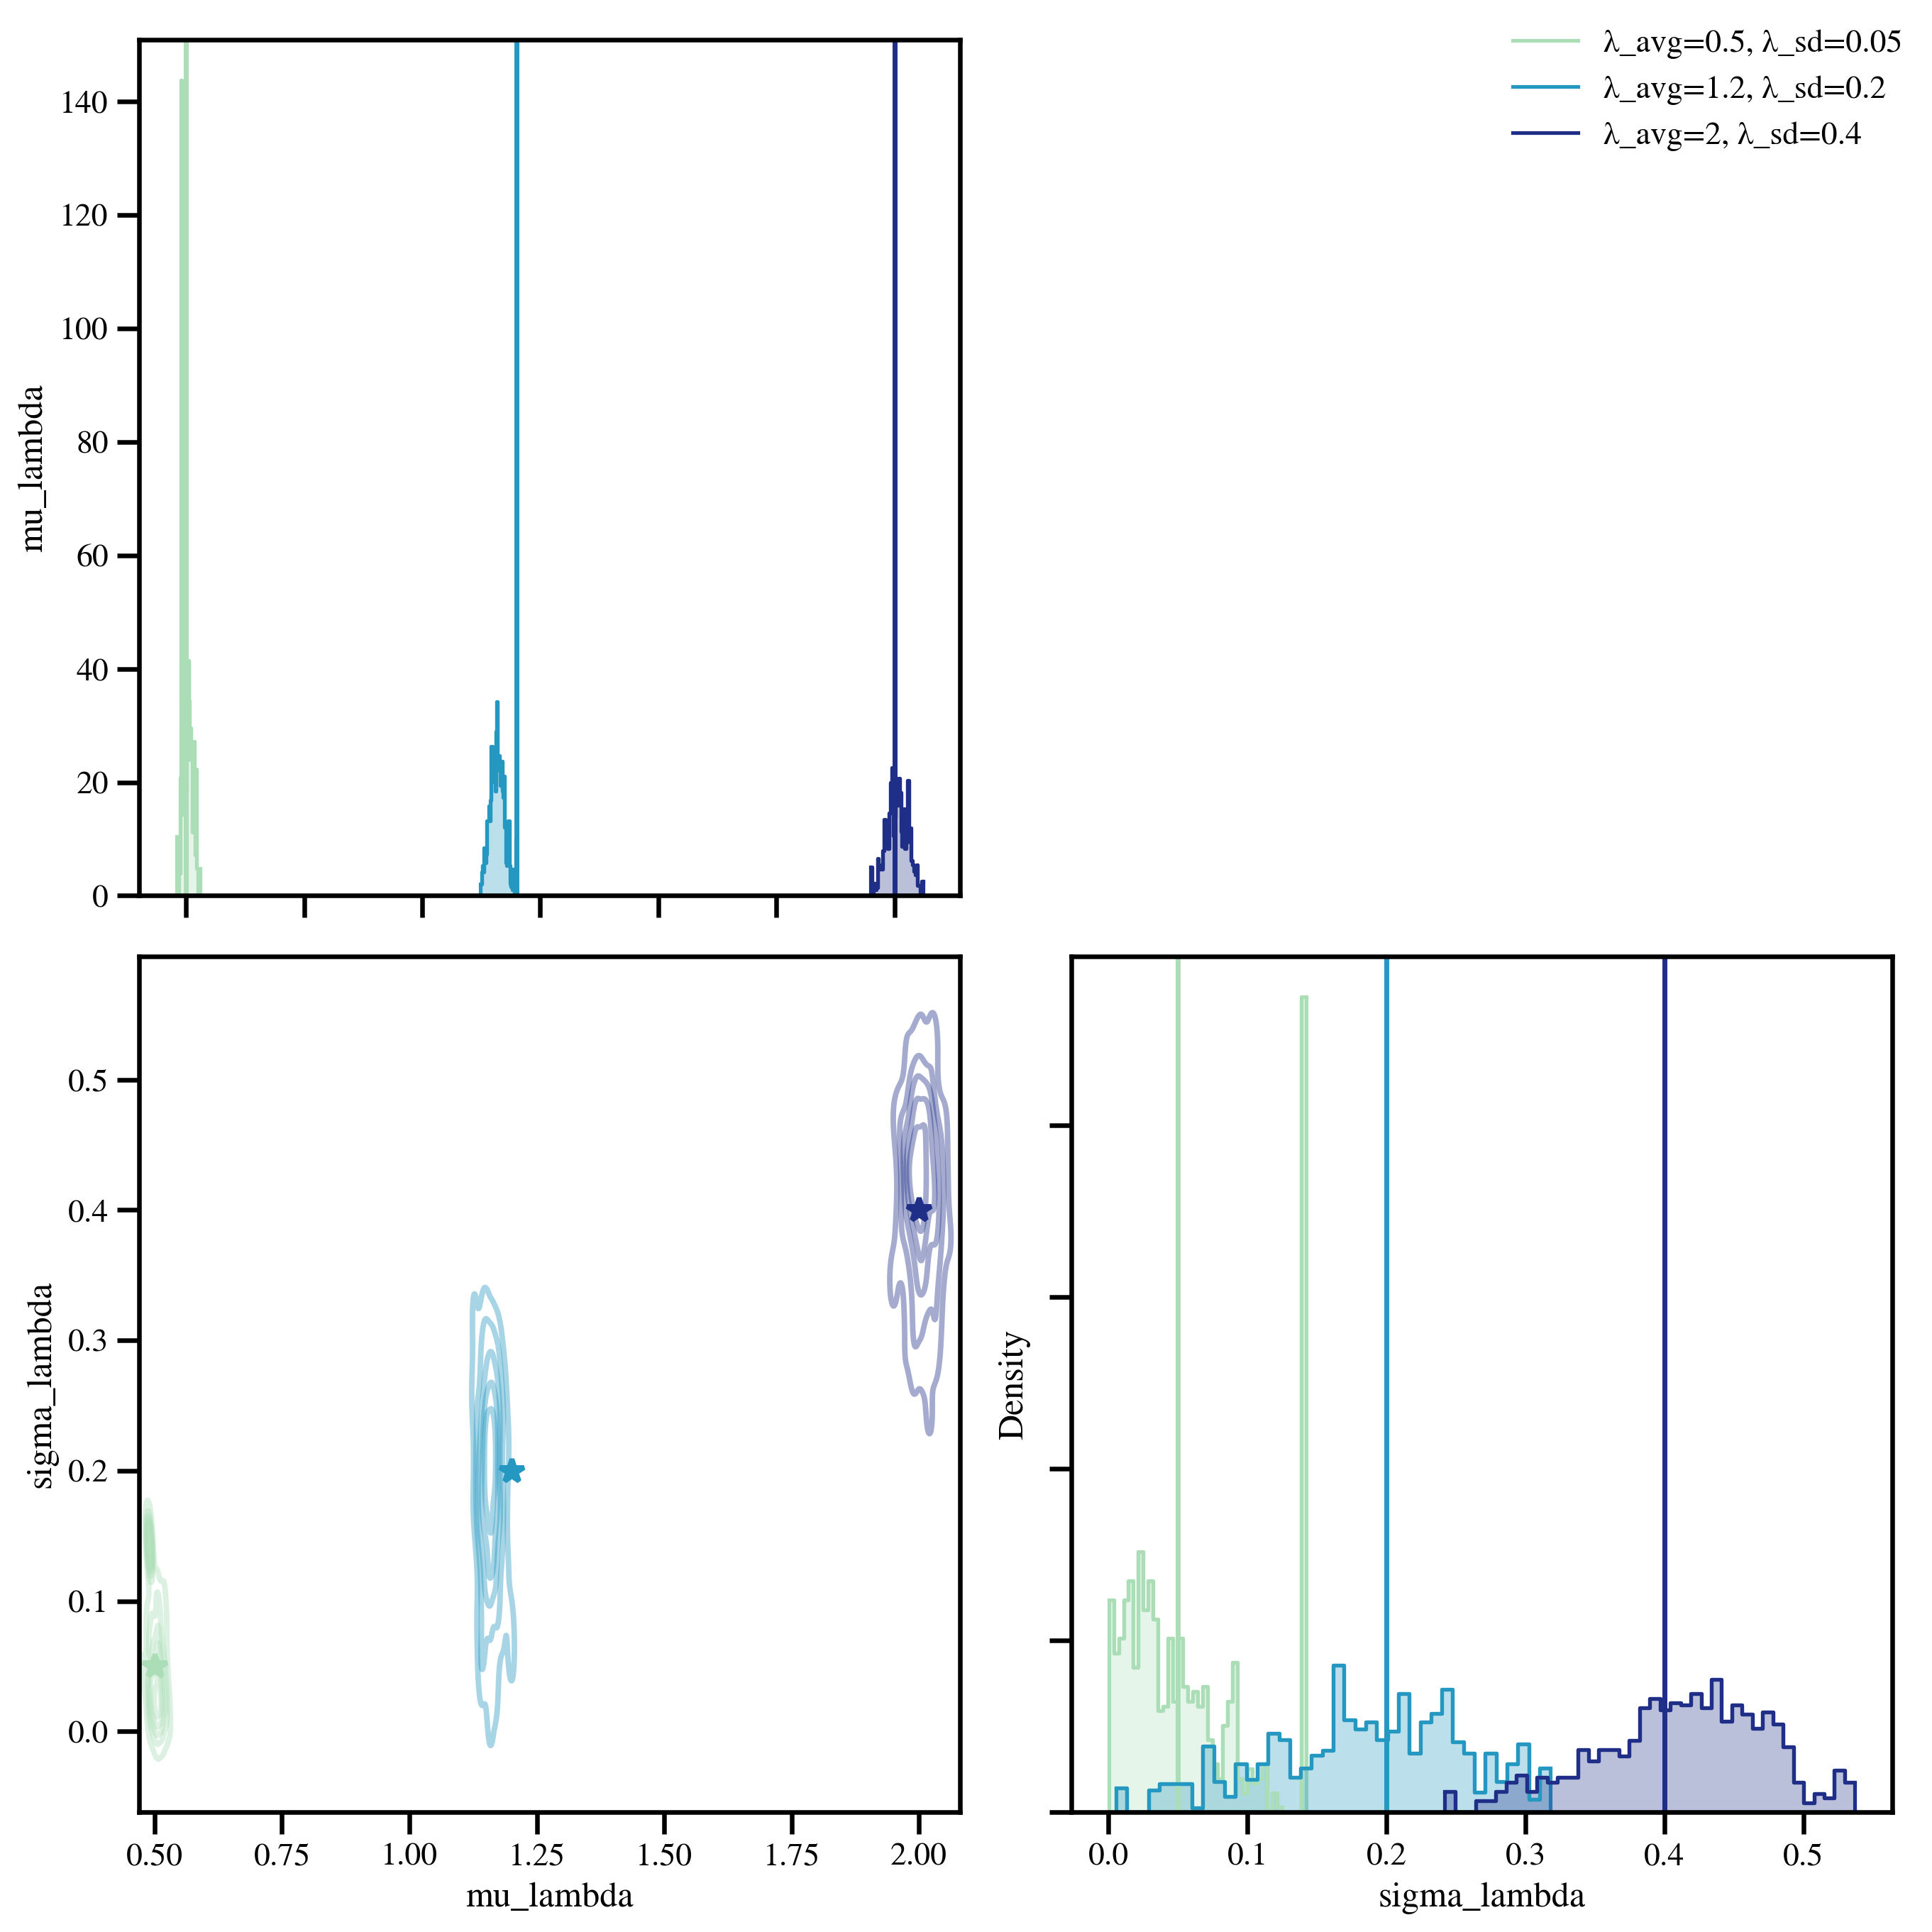

In [ ]:
def plot_joint_posteriors(
    idatas,
    ground_truth=None,
    parameters=None,
    hdi_prob=0.95,
    sample_size=200000,
    save_pdf=False,
    diagonal_style="hist",
    marginal_style="circle",
    pdf_path="joint_posteriors.pdf",
    cmap_name="YlGnBu",
    font_scale=0.8,
):
    sns.set_context("talk", font_scale=font_scale)
    cmap = plt.colormaps.get_cmap(cmap_name)
    colors = cmap(np.linspace(0.3, 0.9, len(idatas)))
    label_to_df = {}
    for label, idata in idatas:
        posterior = idata.posterior
        if parameters is None:
            parameters = [v for v in posterior.data_vars if posterior[v].ndim <= 2]
        df = pd.DataFrame({p: posterior[p].stack(sample=("chain", "draw")).values.ravel() for p in parameters})
        if len(df) > sample_size:
            df = df.sample(sample_size, replace=False)
        df["label"] = label
        label_to_df[label] = df
    npar = len(parameters)
    fig, axes = plt.subplots(npar, npar, figsize=(5.5 * npar, 5.5 * npar), dpi=250)
    for i, rowpar in enumerate(parameters):
        for j, colpar in enumerate(parameters):
            ax = axes[i, j] if npar > 1 else axes
            if j > i:
                ax.axis("off")
                continue
            for color, (label, df) in zip(colors, label_to_df.items()):
                if i == j:
                    vals = df[rowpar].dropna().values
                    if diagonal_style == "kde":
                        sns.kdeplot(vals, ax=ax, fill=True, color=color, alpha=0.3, linewidth=1.2, label=label if i == 0 else None)
                    else:
                        sns.histplot(vals, bins=40, stat="density", color=color, alpha=0.3, element="step", fill=True, ax=ax)
                        sns.histplot(vals, bins=40, stat="density", color=color, alpha=1.0, element="step", fill=False, linewidth=1.5, ax=ax, label=label if i == 0 else None)
                    if ground_truth and label in ground_truth and rowpar in ground_truth[label]:
                        ax.axvline(ground_truth[label][rowpar], color=color, linestyle='-', linewidth=2)
                else:
                    if marginal_style == "circle":
                        sns.kdeplot(x=df[colpar], y=df[rowpar], ax=ax, fill=False, color=color, alpha=0.4, levels=6)
                    else:
                        sns.histplot(x=df[colpar], y=df[rowpar], bins=30, pthresh=0.01, cmap=cmap_name, cbar=False, ax=ax)
                    if ground_truth and label in ground_truth:
                        if colpar in ground_truth[label] and rowpar in ground_truth[label]:
                            ax.plot(ground_truth[label][colpar], ground_truth[label][rowpar],
                                    marker='*', color=color, markersize=10, markeredgewidth=2, linestyle='None')
            if i == npar - 1:
                ax.set_xlabel(colpar)
            else:
                ax.set_xticklabels([])
            if j == 0:
                ax.set_ylabel(rowpar)
            else:
                ax.set_yticklabels([])
    handles, labels = axes[0, 0].get_legend_handles_labels() if npar > 1 else ax.get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc="upper right", frameon=False)
    plt.tight_layout()
    if save_pdf:
        plt.savefig(pdf_path, dpi=300, bbox_inches="tight")
    plt.show()

plot_joint_posteriors(
    idatas,
    ground_truth=ground_truth_values,
    parameters=["mu_lambda", "sigma_lambda"],
    hdi_prob=0.95,
    sample_size=10000,
    # save_pdf=True,
    # pdf_path="joint_posteriors_8000cells_ana.pdf"
)   

In [37]:
import numpy as np
from numpy.polynomial.laguerre import laggauss
import math

# --- Diagnostic functions ---
def logpmf_numeric(y, mu, sigma, x_nodes, w_weights):
    alpha = (mu / sigma) ** 2
    beta  = mu / (sigma**2)
    power = alpha + y - 1.0
    u = np.log(w_weights) + power * np.log(x_nodes)  # <-- fix here
    m = u.max()
    integral = np.exp(m) * np.sum(np.exp(u - m))
    return (alpha*np.log(beta)
            - np.log(math.gamma(alpha))
            - np.log(math.factorial(int(y)))
            - (alpha + y) * np.log(beta + 1.0)
            + np.log(integral))

def logpmf_nb(y, mu, sigma):
    """Analytic log-PMF using Negative Binomial closed form."""
    alpha = (mu / sigma) ** 2
    beta  = mu / (sigma**2)
    return (
        math.lgamma(alpha + y)
        - math.lgamma(alpha)
        - math.lgamma(y + 1)
        + alpha * math.log(beta / (beta + 1))
        + y * math.log(1 / (beta + 1))
    )

# --- Compare numeric vs analytic across parameter values ---
x_nodes, w_weights = laggauss(128)
test_cases = [(0.5, 0.05), (1.2, 0.2), (2.0, 0.4)]
ys = range(0, 8)

print("Diagnostic: Numeric vs Analytic log-pmf differences")
for mu, sigma in test_cases:
    print(f"\nμ={mu}, σ={sigma}")
    for y in ys:
        ln_num = logpmf_numeric(y, mu, sigma, x_nodes, w_weights)
        ln_ana = logpmf_nb(y, mu, sigma)
        print(f" y={y:2d} | num={ln_num:+.6f} | ana={ln_ana:+.6f} | Δ={ln_num - ln_ana:+.3e}")


Diagnostic: Numeric vs Analytic log-pmf differences

μ=0.5, σ=0.05
 y= 0 | num=-0.498754 | ana=-0.498754 | Δ=-3.599e-13
 y= 1 | num=-1.196889 | ana=-1.196889 | Δ=-2.602e-13
 y= 2 | num=-2.578220 | ana=-2.578220 | Δ=-2.771e-13
 y= 3 | num=-4.355165 | ana=-4.355165 | Δ=-2.327e-13
 y= 4 | num=-6.410035 | ana=-6.410035 | Δ=-2.505e-13
 y= 5 | num=-8.678387 | ana=-8.678387 | Δ=-3.659e-13
 y= 6 | num=-11.119491 | ana=-11.119491 | Δ=-2.665e-13
 y= 7 | num=-13.705267 | ana=-13.705267 | Δ=-4.299e-13

μ=1.2, σ=0.2
 y= 0 | num=-1.180434 | ana=-1.180434 | Δ=-2.713e-13
 y= 1 | num=-1.030902 | ana=-1.030902 | Δ=-2.598e-13
 y= 2 | num=-1.547118 | ana=-1.547118 | Δ=-2.505e-13
 y= 3 | num=-2.442132 | ana=-2.442132 | Δ=-2.647e-13
 y= 4 | num=-3.598852 | ana=-3.598852 | Δ=-2.576e-13
 y= 5 | num=-4.953397 | ana=-4.953397 | Δ=-2.487e-13
 y= 6 | num=-6.465572 | ana=-6.465572 | Δ=-2.771e-13
 y= 7 | num=-8.107800 | ana=-8.107800 | Δ=-2.611e-13

μ=2.0, σ=0.4
 y= 0 | num=-1.924026 | ana=-1.924026 | Δ=-2.951e-13
